In [1]:
from abc import abstractmethod, ABC
from collections import defaultdict
from random import shuffle, random, sample, randint
import numpy as np
import pandas as pd
from negmas import (
    Action,
    Agent,
    NegotiatorMechanismInterface,
    AgentWorldInterface,
    Breach,
    Contract,
    Issue,
    make_issue,
    LinearUtilityFunction,
    MechanismState,
    Negotiator,
    RandomNegotiator,
    RenegotiationRequest,
    SAONegotiator,
    UtilityFunction,
    World,
    AspirationNegotiator,
    dict2outcome,
)
from negmas.serialization import to_flat_dict
from typing import Callable, List, Optional, Set, Dict, Any, Collection

In [2]:
import warnings

warnings.filterwarnings("ignore")
from IPython.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

In [3]:
# just repeating the code from the previous tutorial
class AWI(AgentWorldInterface):
    @property
    def n_negs(self):
        """Number of negotiations an agent can start in a step (holiday season)"""
        return self._world.neg_quota_step

    @property
    def agents(self):
        """List of all other agent IDs"""
        return list(_ for _ in self._world.agents.keys() if _ != self.agent.id)

    def request_negotiation(
        self, partners: List[str], negotiator: SAONegotiator
    ) -> bool:
        """A convenient way to request negotiations"""
        if self.agent.id not in partners:
            partners.append(self.agent.id)
        req_id = self.agent.create_negotiation_request(
            issues=self._world.ISSUES,
            partners=partners,
            negotiator=negotiator,
            annotation=dict(),
            extra=dict(negotiator_id=negotiator.id),
        )
        return self.request_negotiation_about(
            issues=self._world.ISSUES, partners=partners, req_id=req_id
        )


class TripsWorld(World):
    ISSUES = [
        make_issue((0, 100), "cost"),
        make_issue(2, "active"),
        make_issue((1, 7), "duration"),
    ]

    def __init__(self, *args, **kwargs):
        """Initialize the world"""
        kwargs["awi_type"] = AWI
        kwargs["negotiation_quota_per_step"] = kwargs.get(
            "negotiation_quota_per_step", 8
        )
        kwargs["force_signing"] = True
        kwargs["default_signing_delay"] = 0
        super().__init__(*args, **kwargs)
        self._contracts: Dict[int, List[Contract]] = defaultdict(list)
        self._total_utility: Dict[str, float] = defaultdict(float)
        self._ufuns: Dict[str, UtilityFunction] = dict()
        self._breach_prob: Dict[str, float] = dict()

    def join(self, x, ufun=None, breach_prob=None, **kwargs):
        """Define the ufun and breach-probability for each agent"""
        super().join(x, **kwargs)
        weights = (np.random.rand(len(self.ISSUES)) - 0.5).tolist()
        weights = [_ / i.max_value for _, i in zip(weights, self.ISSUES)]
        x.ufun = (
            LinearUtilityFunction(
                weights=weights, reserved_value=0.0, issues=self.ISSUES
            )
            if ufun is None
            else ufun
        )
        self._ufuns[x.id] = x.ufun
        self._breach_prob[x.id] = random() * 0.1 if breach_prob is None else breach_prob

    def simulation_step(self, stage: int = 0):
        """What happens in this world? Nothing"""
        pass

    def get_private_state(self, agent: Agent) -> dict:
        """What is the information available to agents? total utility points"""
        return dict(total_utility=self._total_utility[agent.id])

    def execute_action(
        self, action: Action, agent: Agent, callback: Callable | None = None
    ) -> bool:
        """Executing actions by agents? No actions available"""
        pass

    def on_contract_signed(self, contract: Contract) -> None:
        """Save the contract to be executed in the following hoiday season (step)"""
        super().on_contract_signed(contract)
        self._contracts[self.current_step + 1].append(contract)

    def executable_contracts(self) -> Collection[Contract]:
        """What contracts are to be executed in the current step?
        Ones that were signed the previous step"""
        return self._contracts[self.current_step]

    def order_contracts_for_execution(
        self, contracts: Collection[Contract]
    ) -> Collection[Contract]:
        """What should be the order of contract execution? Random"""
        shuffle(contracts)
        return contracts

    def start_contract_execution(self, contract: Contract) -> Optional[Set[Breach]]:
        """What should happen when a contract comes due?
        1. Find out if it will be breached
        2. If not, add to each agent its utility from the trip
        """
        breaches = []
        for aid in contract.partners:
            if random() < self._breach_prob[aid]:
                breaches.append(
                    Breach(
                        contract,
                        aid,
                        "breach",
                        victims=[_ for _ in contract.partners if _ != aid],
                    )
                )
        if len(breaches) > 0:
            return set(breaches)
        for aid in contract.partners:
            self._total_utility[aid] += self._ufuns[aid](
                dict2outcome(contract.agreement, issues=self.ISSUES)
            )
        return set()

    def complete_contract_execution(
        self, contract: Contract, breaches: List[Breach], resolution: Contract
    ) -> None:
        """What happens if a breach was resolved? Nothing. They cannot"""
        pass

    def delete_executed_contracts(self) -> None:
        """Removes all contracts for the current step"""
        if self._current_step in self._contracts.keys():
            del self._contracts[self.current_step]

    def contract_record(self, contract: Contract) -> Dict[str, Any]:
        """Convert the contract into a dictionary for saving"""
        return to_flat_dict(contract)

    def breach_record(self, breach: Breach) -> Dict[str, Any]:
        """Convert the breach into a dictionary for saving"""
        return to_flat_dict(breach)

    def contract_size(self, contract: Contract) -> float:
        """How good is a contract? Welfare"""
        if contract.agreement is None:
            return 0.0
        return sum(
            self._ufuns[aid](dict2outcome(contract.agreement, issues=self.ISSUES))
            for aid in contract.partners
        )

    def post_step_stats(self):
        for aid, agent in self.agents.items():
            self._stats[f"total_utility_{agent.name}"].append(self._total_utility[aid])


class Person(Agent, ABC):
    @abstractmethod
    def step(self): ...

    @abstractmethod
    def init(self): ...

    @abstractmethod
    def respond_to_negotiation_request(
        self,
        initiator: str,
        partners: List[str],
        mechanism: NegotiatorMechanismInterface,
    ) -> Optional[Negotiator]: ...

    def _respond_to_negotiation_request(
        self,
        initiator: str,
        partners: List[str],
        issues: List[Issue],
        annotation: Dict[str, Any],
        mechanism: NegotiatorMechanismInterface,
        role: Optional[str],
        req_id: Optional[str],
    ) -> Optional[Negotiator]:
        return self.respond_to_negotiation_request(initiator, partners, mechanism)

    def on_neg_request_rejected(self, req_id: str, by: Optional[List[str]]):
        pass

    def on_neg_request_accepted(
        self, req_id: str, mechanism: NegotiatorMechanismInterface
    ):
        pass

    def on_negotiation_failure(
        self,
        partners: List[str],
        annotation: Dict[str, Any],
        mechanism: NegotiatorMechanismInterface,
        state: MechanismState,
    ) -> None:
        pass

    def on_negotiation_success(
        self, contract: Contract, mechanism: NegotiatorMechanismInterface
    ) -> None:
        pass

    def set_renegotiation_agenda(
        self, contract: Contract, breaches: List[Breach]
    ) -> Optional[RenegotiationRequest]:
        pass

    def respond_to_renegotiation_request(
        self, contract: Contract, breaches: List[Breach], agenda: RenegotiationRequest
    ) -> Optional[Negotiator]:
        pass

    def on_contract_executed(self, contract: Contract) -> None:
        pass

    def on_contract_breached(
        self, contract: Contract, breaches: List[Breach], resolution: Optional[Contract]
    ) -> None:
        pass

## Develop a new agent (for your simulation)

In the previous tutorial, we implemented a world simulation called `TripsWorld` in which agents negotiated how to spend their holiday seasons. In this tutorial we will develop agents for this world and take it on a test-drive.


### Making a Random Agent for the Trips World

Our random agent, will just use a random negotiator for everything and will not keep track of the history of other agents. That is the complete code which is self explanatory this time.

In [4]:
class RandomPerson(Person):
    def step(self):
        # get IDs of all ogher agents from the AWI
        agents = self.awi.agents
        # request the maximum number of negotiations possible
        for _ in range(self.awi.n_negs):
            # for each negotiation, use a random subset of partners and a random negotiator
            self.awi.request_negotiation(
                partners=sample(agents, k=randint(1, len(agents) - 1)),
                negotiator=RandomNegotiator(),
            )

    def init(self):
        # we need no initialization
        pass

    def respond_to_negotiation_request(
        self,
        initiator: str,
        partners: List[str],
        mechanism: NegotiatorMechanismInterface,
    ) -> Optional[Negotiator]:
        # just us a random negotiator for everything
        return RandomNegotiator()

### Testing the world

We can now start world simulations using our new world and agent

In [5]:
world = TripsWorld(n_steps=10, construct_graphs=True)
for i in range(5):
    world.join(RandomPerson(name=f"a{i}"))
world.run_with_progress()

Output()

Let's see what happened in this run. Firstly, how many negotiations were conducted over time. Our agents always conducted the maximum number of negotiations ($8$) and we had $5$ agents which means we expect $40$ negotiations at every step.

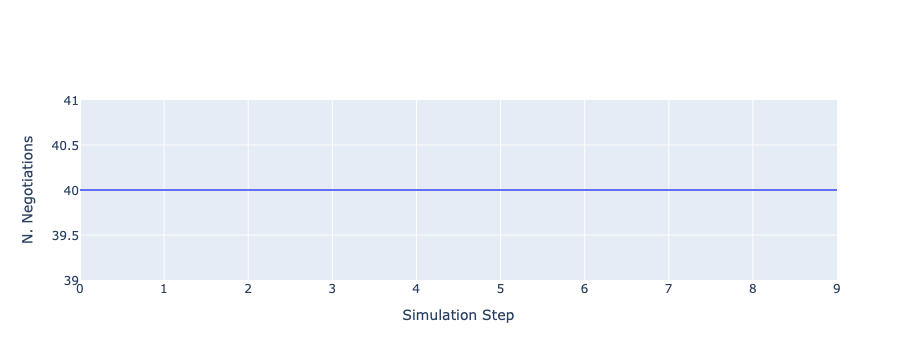

In [6]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(y=world.stats["n_negotiations"], mode="lines"))
fig.update_layout(xaxis_title="Simulation Step", yaxis_title="N. Negotiations")

Let's start by seeing how long did each step take (note that stats access the stats as a Dict[str, List] but stats_df access the same data as a pandas dataframe.



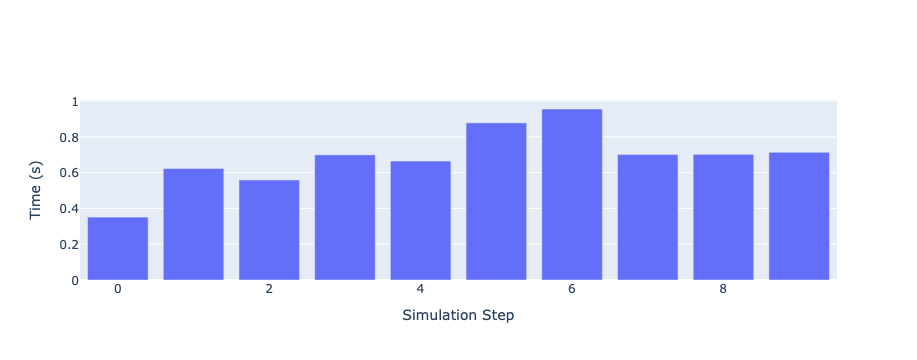

In [8]:
def stats_df(world):
    return pd.DataFrame(world.stats)


import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(x=list(range(world.n_steps)), y=stats_df(world)["step_time"]))
fig.update_layout(xaxis_title="Simulation Step", yaxis_title="Time (s)")

We can for example check the welfare (activity level) of this world (defined as the total contract sizes executed per step which in our case correspond to the total welfare)

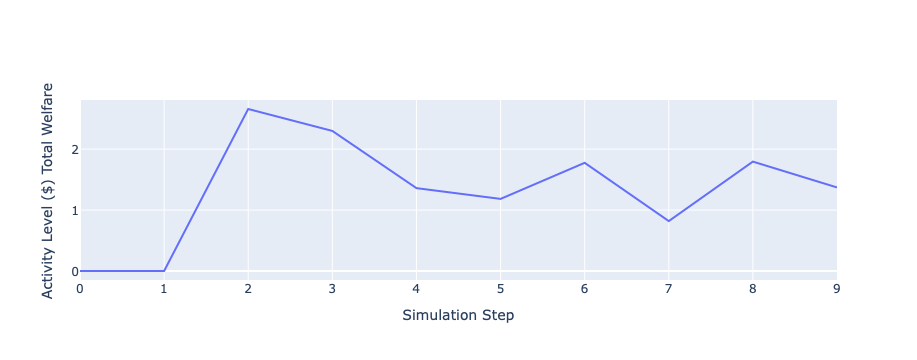

In [9]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(y=world.stats["activity_level"], mode="lines"))
fig.update_layout(
    xaxis_title="Simulation Step", yaxis_title="Activity Level ($)\nTotal Welfare"
)
fig

We can see a picture of contracting in this world as follows:

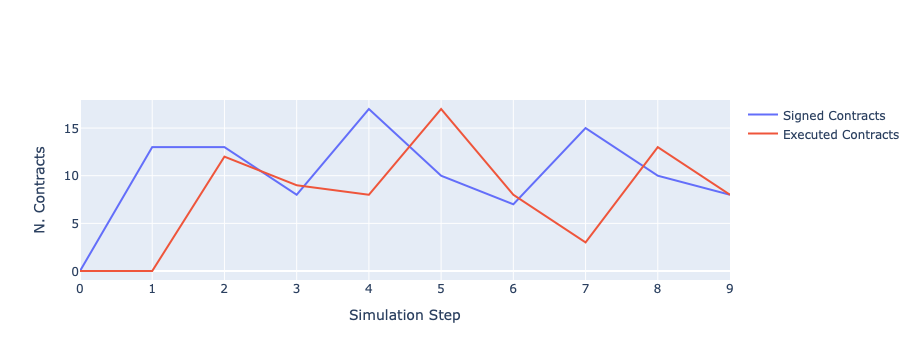

In [10]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        y=world.stats["n_contracts_signed"], mode="lines", name="Signed Contracts"
    )
)
fig.add_trace(
    go.Scatter(
        y=world.stats["n_contracts_executed"], mode="lines", name="Executed Contracts"
    )
)
fig.update_layout(xaxis_title="Simulation Step", yaxis_title="N. Contracts")

We can also check the breaches that happened

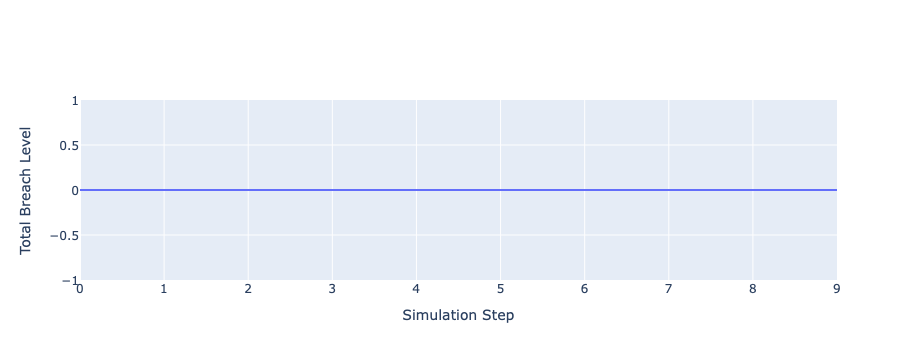

In [11]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(y=world.stats["breach_level"], mode="lines"))
fig.update_layout(xaxis_title="Simulation Step", yaxis_title="Total Breach Level")

We can actually check what happens to ALL agents

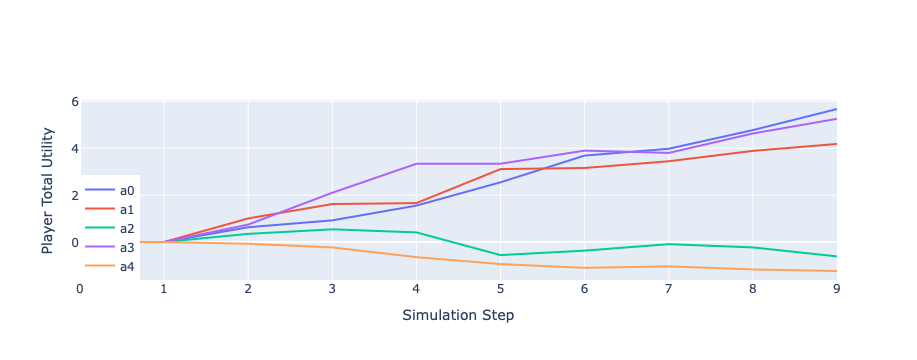

In [12]:
import plotly.graph_objects as go

fig = go.Figure()
snames = sorted(_.name for _ in world.agents.values())
for name in snames:
    fig.add_trace(
        go.Scatter(
            y=np.asarray(world.stats[f"total_utility_{name}"]), mode="lines", name=name
        )
    )
fig.update_layout(
    xaxis_title="Simulation Step",
    yaxis_title="Player Total Utility",
    legend=dict(x=0, y=0),
)
fig

As you can see, the total utility is not monotonically increasing. This means that agents accepted offers that have a utility less than their reserved value. That is expected because we use `RandomNegotiator`s for all negotiations. 

We can also get a graphical view of all activities during the simulation:

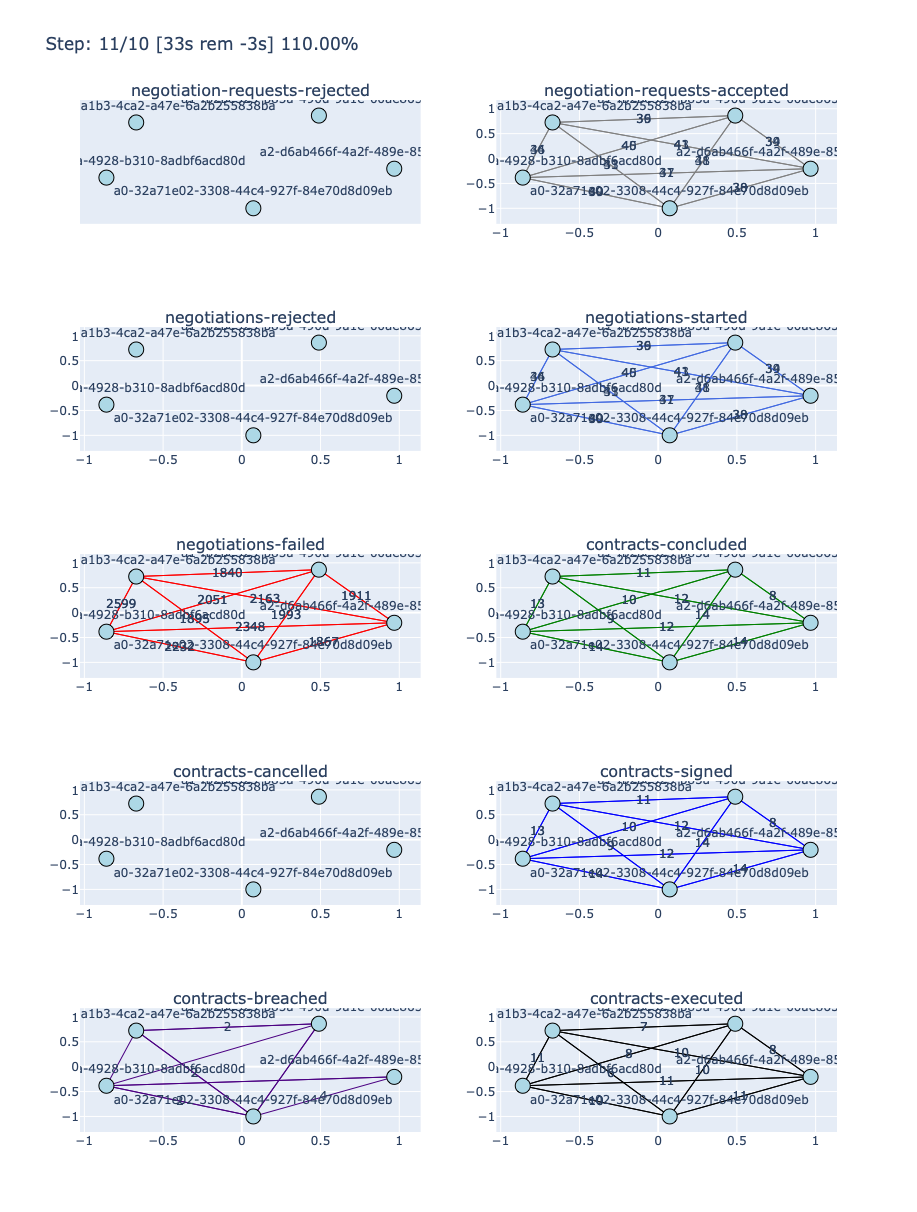

(None,
  <networkx.classes.digraph.DiGraph at 0x11699e750>])

In [13]:
world.draw(steps=(0, world.n_steps), together=False, ncols=2, figsize=(20, 20))

### Making a Better Agent for the Trips World

As we have seen, the random agent did not behave well in this world. It is pretty simple to extend it into a better agent. Here is a simple attempt:

In [14]:
class SanePerson(Person):
    """An agent that uses a predefined negotiator instead of a random negotiator"""

    def __init__(
        self,
        *args,
        negotiator_type=AspirationNegotiator,
        negotiator_params=None,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)
        self.negotiator_type = negotiator_type
        self.negotiator_params = (
            negotiator_params if negotiator_params is not None else dict()
        )

    def step(self):
        # get IDs of all ogher agents from the AWI
        agents = self.awi.agents
        # request the maximum number of negotiations possible
        for _ in range(self.awi.n_negs):
            # for each negotiation, use a random subset of partners and a random negotiator
            self.awi.request_negotiation(
                partners=sample(agents, k=randint(1, 2)),
                negotiator=self.negotiator_type(
                    ufun=self.ufun, **self.negotiator_params
                ),
            )

    def init(self):
        pass

    def respond_to_negotiation_request(
        self, initiator: str, partners: List[str], mechanism
    ) -> Optional[Negotiator]:
        # just us a random negotiator for everything
        return self.negotiator_type(ufun=self.ufun, **self.negotiator_params)

The only difference between this `SanePerson` and the `RandomPerson` we developed earlier is that it can be constructed to use any type of negotiation strategy supported in NegMAS (i.e. any `SAONegotiator` class). Whenever it is asked for a negotiator (either in `step` or `respond_to_negotiation_request`) it uses that negotiator setting its utility function.

Let's try it

In [15]:
world = TripsWorld(n_steps=20, construct_graphs=True)
for i in range(3):
    world.join(RandomPerson(name=f"rand-{i}"))
for i in range(3):
    world.join(SanePerson(name=f"sane-{i}"))
world.run_with_progress()

Output()

Let's check how did our agent do

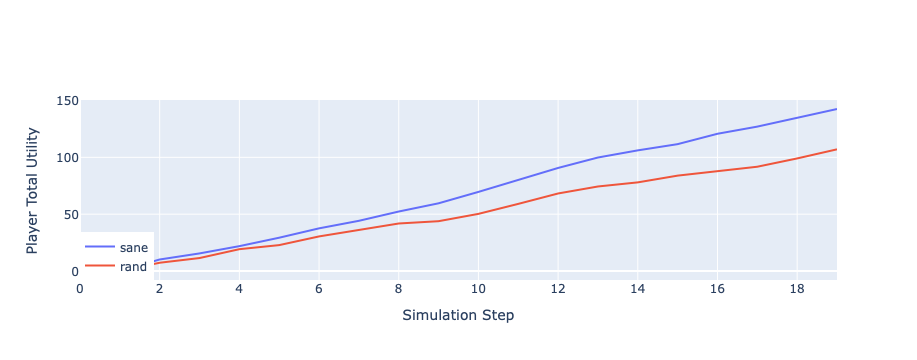

In [17]:
import plotly.graph_objects as go

fig = go.Figure()
snames = sorted(_.name for _ in world.agents.values())
utils = dict(sane=np.zeros(world.n_steps), rand=np.zeros(world.n_steps))
for agent_name in (_.name for _ in world.agents.values()):
    utils[agent_name.split("-")[0]] += np.asarray(
        world.stats[f"total_utility_{agent_name}"]
    )
for name in utils.keys():
    fig.add_trace(go.Scatter(y=utils[name], mode="lines", name=name))
fig.update_layout(
    xaxis_title="Simulation Step",
    yaxis_title="Player Total Utility",
    legend=dict(x=0, y=0),
)
fig

Better. 